In [1]:
## 20180905 runs PD logistic regression models for all banks
## 20170519 modified to product logistic PDs for 2015 and 2016 quarters
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta  ## use this to increment targ by 1 year!!!!
import time
from time import gmtime, strftime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
#import random

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_ult202012.csv", index_col=0)  # ultcert version
rk['xAsOf'] = pd.to_datetime(rk['xAsOf'])
rk['nAsOf'] = pd.to_datetime(rk['nAsOf'])
rk['FailDate'] = pd.to_datetime(rk['FailDate'])
rk.tail(3)

Rank   IDRSSD      xAsOf                                        xName  \
10795  10796  2809355 2002-09-30             FIRST TRUST COMPANY OF ONAGA, NA   
10796  10797  3037904 2002-06-30  MARQUETTE TRUST COMPANY OF SOUTH DAKOTA, NA   
10797  10798  3874891 2008-12-31          TEXAS FIRST BANK - RETAINED CHARTER   

      xState    xCert      nAsOf FailDate BkClass  Offices  ... aeTotLn  \
10795     KS  35589.0 2001-03-31      NaT     NaN      NaN  ...     0.0   
10796     SD  57326.0 2001-12-31      NaT     NaN      NaN  ...     0.0   
10797     TX  21960.0 2008-12-31      NaT      NM      1.0  ...     0.0   

       aeDDep aeFDep  aeTotDep        pr_eTA    pr_eTAcs  pr_eTL  pr_eTLcs  \
10795     0.0    0.0       0.0  4.103493e-06   99.999998     0.0     100.0   
10796     0.0    0.0       0.0  1.710903e-06  100.000000     0.0     100.0   
10797    66.0    0.0      66.0  3.862701e-07  100.000000     0.0     100.0   

             pr_eDD    pr_eDDcs  
10795  0.000000e+00  111.532977  
10796  0.000000e+00  111.532977  
10797  6.801992e-07  111.532978  

[3 rows x 27 columns]

In [3]:
dfz = pd.read_csv("df3z_202012_allbanks.csv") 
dfz['AsOf'] = pd.to_datetime(dfz['AsOf'])
#dfz = dfz[dfz['AsOf']<='2014-12-31']  # does not work if AsOf > 2014-12-31 (this has been fixed: 20170519)
dfcol = list(dfz.columns)
dfz.columns

Index(['Unnamed: 0', 'IDRSSD', 'AsOf', 'Name', 'State', 'Cert', 'eTotAst',
       'qNetInc', 'qNetII', 'qProv',
       ...
       'eTotrb', 'eALLL_Ln', 'mxCx', 'mxSfFst', 'mxCRE', 'mxCI', 'mxCard',
       'mxDDA', 'eRWA_TA', 'lnTotAst'],
      dtype='object', length=134)

In [4]:
len(dfz) # 568386

568386

In [5]:
rk[0:5]

Rank  IDRSSD      xAsOf                    xName xState    xCert  \
0     1  852218 2020-12-31  JPMORGAN CHASE BANK, NA     OH    628.0   
1     2  480228 2020-12-31      BANK OF AMERICA, NA     NC   3510.0   
2     3  476810 2020-12-31           CITIBANK, N.A.     SD   7213.0   
3     4  451965 2020-12-31     WELLS FARGO BANK, NA     SD   3511.0   
4     5  484422 2009-12-31        WACHOVIA BANK, NA     NC  33869.0   

       nAsOf   FailDate BkClass  Offices  ...       aeTotLn        aeDDep  \
0 2001-03-31        NaT       N   4987.0  ...  5.652142e+08  7.671177e+08   
1 2001-03-31 2009-01-16       N   4239.0  ...  6.952804e+08  8.832854e+08   
2 2001-03-31 2008-11-23       N    703.0  ...  5.233710e+08  3.160202e+08   
3 2001-03-31        NaT       N   5084.0  ...  5.772582e+08  6.953574e+08   
4 2001-03-31        NaT       N   3312.0  ...  2.546369e+08  2.704156e+08   

         aeFDep      aeTotDep    pr_eTA   pr_eTAcs    pr_eTL   pr_eTLcs  \
0  2.613865e+08  1.028504e+09  9.324842   9.324842  5.825125   5.825125   
1  1.040564e+08  9.873418e+08  7.848688  17.173530  7.165594  12.990719   
2  4.547897e+08  7.708099e+08  6.507073  23.680603  5.393887  18.384606   
3  6.515955e+07  7.605170e+08  5.716821  29.397424  5.949251  24.333857   
4  2.469325e+07  2.951088e+08  2.584770  31.982194  2.624301  26.958158   

     pr_eDD   pr_eDDcs  
0  7.905952   7.905952  
1  9.103182  17.009134  
2  3.256919  20.266053  
3  7.166387  27.432440  
4  2.786916  30.219356  

[5 rows x 27 columns]

In [6]:
dfcol[-56:][0:5]  ## want to start with rcTotLn as first of all ratios

['rcTotLn', 'rcCx', 'rcSfRev', 'rcSfTD', 'rcMult']

In [7]:
xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eBrok_Dep','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
#xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
xcol

['rcTotLn',
 'qnTotLn',
 'rNIM',
 'rPPNR',
 'rROA',
 'rROE',
 'rEff',
 'eLn_Dep',
 'aFF_TA',
 'eBrok_Dep',
 'eT1rb',
 'eTotrb',
 'eALLL_Ln',
 'lnTotAst']

In [8]:
#dfz['AsOf'] = pd.to_datetime(dfz['AsOf'])
dfr = dfz[dfz['AsOf']>='2001-12-31'][['IDRSSD','AsOf','Name','State','eTotAst']+xcol]

In [9]:
dfr.tail(2)

IDRSSD       AsOf               Name State   eTotAst  rcTotLn  \
568384  5518023 2020-12-31      VARO BANK, NA    UT  515114.0      NaN   
568385  5538937 2020-12-31  CLASSIC CITY BANK    GA   38288.0      NaN   

         qnTotLn  rNIM  rPPNR  rROA  rROE  rEff     eLn_Dep     aFF_TA  \
568384  0.196409   NaN    NaN   NaN   NaN   NaN    0.858235  86.044411   
568385  0.000000   NaN    NaN   NaN   NaN   NaN  111.167937  17.905653   

        eBrok_Dep         eT1rb     eTotrb   eALLL_Ln   lnTotAst  
568384        0.0  6.729700e+06   0.000000  54.573513  13.152144  
568385        0.0  8.499688e+01  86.181106   1.248709  10.552892

In [10]:
len(dfr) # 541981

541981

In [11]:
## add faildate (if it hasn't already been added):
if 'FailDate' not in list(dfr.columns): dfr = dfr.merge(rk[['IDRSSD','FailDate']],how='left',on='IDRSSD')

In [12]:
## calculate months-to-fail (mtf) and fail flags (f6 and f12):
dfr['mtf'] = ((dfr['FailDate'] - dfr['AsOf'])/np.timedelta64(1,'M')) 
dfr['mtf2'] = dfr.apply(lambda x: round(x['mtf'],0),axis=1)
dfr['f2'] = ((dfr['mtf'] <= 6.0) & (dfr['mtf'] >= 0.0))*1
dfr['f4'] = ((dfr['mtf'] <= 12.0) & (dfr['mtf'] >= 0.0))*1
dfr['f6'] = ((dfr['mtf'] <= 18.0) & (dfr['mtf'] >= 0.0))*1
dfr['f8'] = ((dfr['mtf'] <= 24.0) & (dfr['mtf'] >= 0.0))*1
dfr[dfr['FailDate']>'1990'].tail(10)

IDRSSD       AsOf                   Name State  eTotAst    rcTotLn  \
536614  3640854 2010-12-31  PISGAH COMMUNITY BANK    NC  42376.0  28.150487   
536615  3640854 2011-03-31  PISGAH COMMUNITY BANK    NC  37254.0   8.929288   
536616  3640854 2011-06-30  PISGAH COMMUNITY BANK    NC  30273.0   8.503535   
536617  3640854 2011-09-30  PISGAH COMMUNITY BANK    NC  30326.0   6.575220   
536618  3640854 2011-12-31  PISGAH COMMUNITY BANK    NC  28120.0   1.430248   
536619  3640854 2012-03-31  PISGAH COMMUNITY BANK    NC  27152.0   2.384150   
536620  3640854 2012-06-30  PISGAH COMMUNITY BANK    NC  27272.0   3.607183   
536621  3640854 2012-09-30  PISGAH COMMUNITY BANK    NC  27126.0   2.767538   
536622  3640854 2012-12-31  PISGAH COMMUNITY BANK    NC  24844.0   3.571429   
536623  3640854 2013-03-31  PISGAH COMMUNITY BANK    NC  21880.0   4.476975   

          qnTotLn      rNIM     rPPNR       rROA  ...    eTotrb   eALLL_Ln  \
536614  23.925972  1.477079 -1.921769 -18.226779  ...  1.820415   4.658121   
536615  17.008591  1.501112 -3.117728 -10.539127  ...  4.962240   9.265289   
536616  21.446963  1.627686 -4.269489 -10.664828  ...  4.205588   9.130049   
536617  22.193740  1.812781 -5.113951 -11.027282  ...  3.881005   8.688613   
536618  18.812332  2.028930 -6.126587  -9.089617  ...  4.278839   9.745355   
536619  25.039539  2.097654 -6.350320  -6.577475  ...  4.561760  10.918437   
536620  24.826110  2.210453 -7.173657  -7.180697  ...  4.254765   8.768801   
536621  30.337148  2.105704 -7.160776  -7.164372  ...  4.221197   8.890119   
536622  20.492884  1.927205 -7.261747  -7.265452  ...  4.766264   9.330094   
536623  19.035231  1.919126 -6.838070  -5.395423  ...  5.006596   6.525940   

         lnTotAst   FailDate        mtf  mtf2  f2  f4  f6 f8  
536614  10.654337 2013-05-10  28.288055  28.0   0   0   0  0  
536615  10.525515 2013-05-10  25.331116  25.0   0   0   0  0  
536616  10.318012 2013-05-10  22.341321  22.0   0   0   0  1  
536617  10.319761 2013-05-10  19.318672  19.0   0   0   0  1  
536618  10.244236 2013-05-10  16.296023  16.0   0   0   1  1  
536619  10.209206 2013-05-10  13.306228  13.0   0   0   1  1  
536620  10.213616 2013-05-10  10.316434  10.0   0   1   1  1  
536621  10.208248 2013-05-10   7.293784   7.0   0   1   1  1  
536622  10.120372 2013-05-10   4.271135   4.0   1   1   1  1  
536623   9.993328 2013-05-10   1.314195   1.0   1   1   1  1  

[10 rows x 26 columns]

In [13]:
dfr[dfr['FailDate']>'1990'][['AsOf','IDRSSD','FailDate','mtf','mtf2']].tail(10)

AsOf   IDRSSD   FailDate        mtf  mtf2
536614 2010-12-31  3640854 2013-05-10  28.288055  28.0
536615 2011-03-31  3640854 2013-05-10  25.331116  25.0
536616 2011-06-30  3640854 2013-05-10  22.341321  22.0
536617 2011-09-30  3640854 2013-05-10  19.318672  19.0
536618 2011-12-31  3640854 2013-05-10  16.296023  16.0
536619 2012-03-31  3640854 2013-05-10  13.306228  13.0
536620 2012-06-30  3640854 2013-05-10  10.316434  10.0
536621 2012-09-30  3640854 2013-05-10   7.293784   7.0
536622 2012-12-31  3640854 2013-05-10   4.271135   4.0
536623 2013-03-31  3640854 2013-05-10   1.314195   1.0

In [14]:
## issues:  Ln_Dep, Brok_Dep ratios:
dfr[['eLn_Dep','aFF_TA','eBrok_Dep','eALLL_Ln']].max()

eLn_Dep      1.188277e+08
aFF_TA       1.242405e+03
eBrok_Dep    7.002056e+03
eALLL_Ln     1.500000e+04
dtype: float64

In [15]:
dfr.ix[dfr['eLn_Dep'].idxmax()]

IDRSSD                               3376461
AsOf                     2005-09-30 00:00:00
Name         LEHMAN BROTHERS COMMERCIAL BANK
State                                     UT
eTotAst                          1.32523e+06
rcTotLn                                  NaN
qnTotLn                                    0
rNIM                                     NaN
rPPNR                                    NaN
rROA                                     NaN
rROE                                     NaN
rEff                                     NaN
eLn_Dep                          1.18828e+08
aFF_TA                               3.85946
eBrok_Dep                                  0
eT1rb                                15.0255
eTotrb                               15.0255
eALLL_Ln                                   0
lnTotAst                             14.0971
FailDate                                 NaT
mtf                                      NaN
mtf2                                     NaN
f2        

In [16]:
## Don't repeat this unless something has changed!!!!!!!!!
dfr.to_csv("logistic_rawdata.csv")

In [17]:
len(dfr) # 541981

541981

In [18]:
dfr.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8'],
      dtype='object')

In [19]:
## curr date is 2010-12-31, but cut off dataset at 2009-12-31, then adjust for any fail flags later than 2010-12-31:
targ = pd.to_datetime('2009-12-31')
thresh = 0
alt = 'roe' ## or alt = ''  # add rROE >=-200 screening test
dfh = dfr[(dfr['AsOf']<=targ)][['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']+xcol]
#dfr09 = sm.add_constant(dfr09)
len(dfh) # 265388

265388

In [20]:
dfh.columns[8:]

Index(['rcTotLn', 'qnTotLn', 'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff',
       'eLn_Dep', 'aFF_TA', 'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln',
       'lnTotAst'],
      dtype='object')

In [21]:
dfh[['eLn_Dep','aFF_TA','eBrok_Dep','eALLL_Ln']].max()

eLn_Dep      1.188277e+08
aFF_TA       1.242405e+03
eBrok_Dep    7.002056e+03
eALLL_Ln     1.500000e+04
dtype: float64

In [22]:
## screening criteria, remove outliers: (10/29/15 add eT1rb and lnTotAst screens)
dfh.dropna(how='any',inplace=True,subset=dfh.columns[8:])  # delete any ratio columns with NaN values (note columns[8:])
dfh= dfh[dfh['eLn_Dep']<=1000]
dfh= dfh[dfh['eBrok_Dep']<=100]
dfh= dfh[dfh['eALLL_Ln']<=100]
dfh= dfh[dfh['rROE']>=-200]
dfh= dfh[dfh['eT1rb']<=200]   # added 10/29/15
dfh= dfh[dfh['lnTotAst']>=2]  # added 10/29/15
len(dfh) # 259210

259210

In [23]:
# 20160428 handles leap years now.
targ2 = pd.to_datetime(targ.day + targ.month*100 + (targ.year + 1)*10000,format='%Y%m%d')
targ2, targ

(Timestamp('2010-12-31 00:00:00'), Timestamp('2009-12-31 00:00:00'))

In [24]:
## set fflags to zero if FailDate after target date (12/31/2009); that is, for f4
dfh.ix[dfh.FailDate>targ2,['f2','f4','f6','f8']] = [0,0,0,0]

In [25]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2012-01-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head()

IDRSSD       AsOf                 Name   FailDate  f2  f4  f6  f8
6237   16337 2009-09-30         WAKULLA BANK 2010-10-01   0   0   1   1
6238   16337 2009-12-31         WAKULLA BANK 2010-10-01   0   1   1   1
8007   20370 2009-09-30  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
8008   20370 2009-12-31  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
9255   23241 2009-09-30      INTEGRA BANK NA 2011-07-29   0   0   0   0

In [26]:
## regressions:
fml = 'f4 ~ ' + ' + '.join(xcol)
fml

'f4 ~ rcTotLn + qnTotLn + rNIM + rPPNR + rROA + rROE + rEff + eLn_Dep + aFF_TA + eBrok_Dep + eT1rb + eTotrb + eALLL_Ln + lnTotAst'

In [27]:
try:
  md = smf.logit(formula=fml, data=dfh).fit()
  print(md.summary())
except:
  print("Full model didn't work")

Optimization terminated successfully.
         Current function value: 0.010300
         Iterations 16
                           Logit Regression Results                           
Dep. Variable:                     f4   No. Observations:               259210
Model:                          Logit   Df Residuals:                   259195
Method:                           MLE   Df Model:                           14
Date:                Fri, 30 Apr 2021   Pseudo R-squ.:                  0.5637
Time:                        09:18:25   Log-Likelihood:                -2669.9
converged:                       True   LL-Null:                       -6119.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.8301      0.442    -10.922      0.000      -5.697      -3.963
rcTotLn       -0.0587      0

In [28]:
## stepwise regressions:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

## create 2-var models:
topx = 2
def dv1_topx(group):
  return group.sort_index(by='r1', ascending=False)[:topx]

dv1 = pd.DataFrame(columns=['fx','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
for fx in ['f2','f4','f6']:
  for v in xcol:
    y, X = dmatrices( fx + ' ~ ' + v , data=dfh, return_type='dataframe')
    try:
      res = sm.Logit(y, X).fit()
      dv1 = dv1.append({'fx': fx,'v1': v, 'r1': res.prsquared}, ignore_index=True)
    except:
      pass

dv1g = dv1.groupby(['fx'])
dv1t = dv1g.apply(dv1_topx)
dv1t.index = np.arange(len(dv1t))

# stores r-sq values for all 2-var combos:
dv2 = pd.DataFrame(columns=['fx','v1', 'r1', 'v2', 'r2'])
st2 = set(frozenset({'fx','x', 'y'}))  # to retain processed var-pairs

for idx, row in dv1t.iterrows():
  for v in xcol:
    if (row['v1'] == v) | ({row['fx'], v , row['v1']} in st2):
      pass
    else:
      y, X = dmatrices( row['fx'] + ' ~ ' + row['v1'] + ' + ' + v , data = dfh, return_type='dataframe')
      try:
        res = sm.Logit(y, X).fit()
        dv2 = dv2.append({'fx':row['fx'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.prsquared}, ignore_index=True)
      except:
        pass
      st2.add(frozenset({row['fx'], v, row['v1']}))

print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


2021-04-30 09:18:33
Optimization terminated successfully.
         Current function value: 0.010621
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009202
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010627
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010364
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009103
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.005401
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.010626
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010606
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010598
         Iterations 11
Optimization terminated successfully.
         Curren

         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.012158
         Iterations 12
         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.013563
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012352
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.014221
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.014218
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.014072
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.013378
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.014221
         Iterations 13
Optimization terminated successfully.
         Current

In [29]:
dv1t

fx      v1        r1
0  f2   eT1rb  0.522124
1  f2  eTotrb  0.499823
2  f4    rROE  0.400128
3  f4   eT1rb  0.397605
4  f6    rROE  0.303982
5  f6   eT1rb  0.290698

In [30]:
# function to select topx for each lead variable:
def get_topx_2var(group):
  return group.sort_index(by=['r2','r1'], ascending=False)[:topx]

grouped = dv2.groupby(['fx'], as_index=False)
dv2a = grouped.apply(get_topx_2var)
dv2a = dv2a.sort_index(by=['fx','r2','r1'], ascending=[True,False,False])
dv2a.index = np.arange(len(dv2a))
dv2a

fx      v1        r1       v2        r2
0  f2   eT1rb  0.522124     rROE  0.574446
1  f2  eTotrb  0.499823     rROE  0.565798
2  f4   eT1rb  0.397605  qnTotLn  0.484993
3  f4    rROE  0.400128    eT1rb  0.479468
4  f6   eT1rb  0.290698  qnTotLn  0.398956
5  f6    rROE  0.303982    eT1rb  0.379662

In [31]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
# prep for 3-var combos:
# stores r-sq values for all 3-var combos:
dv3 = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
cv3 = pd.DataFrame(columns=['idx','v3','Int','c1','c2','c3'])
st3 = set(frozenset({'fx','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in dv2a.iterrows():
  for v in xcol:
    if (row['v1'] == v) | (row['v2'] == v) :
      pass
    elif {row['fx'], v , row['v1'], row['v2']} in st3:
      pass
    else:
      y, X = dmatrices( row['fx'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = dfh, return_type='dataframe')
      try:
        st3.add(frozenset({row['fx'],v, row['v1'], row['v2']}))
        res = sm.Logit(y, X).fit()
        dv3 = dv3.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],\
                          'r2':row['r2'],'v3':v,'r3': res.prsquared},ignore_index=True)
        cm = pd.DataFrame(res.params).T
        cm.columns = ['Int','c1','c2','c3']
        cm['idx'] = idx
        cm['v3'] = v
        cv3 = cv3.append(cm.ix[0])
      except:
        pass

cv3arch = cv3.copy()
dv3arch = dv3.copy()
#cv3.reset_index(drop=True,inplace=True)
dv3.reset_index(drop=True,inplace=True)
dv3 = dv3.merge(cv3, how='inner', on=['idx','v3'])

print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2021-04-30 09:22:40
         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.004270
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004522
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.004522
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.004508
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.004522
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004509
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004499
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004309
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004497
         Iterat

In [32]:
topn = 2
# function to select top 3 for each lead variable:
def get_topx_3var(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]

def get_topn_rc(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

dv3g = dv3.groupby(['fx','v1','v2'])  #  allows topx for each primary 2-var pair
dv3a = dv3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
dv3a.index.names = ['rci','v1i','v2i','i']
dv3ag = dv3a.groupby(['fx'])  # prep to find topn best models for each product category
dv3b = dv3ag.apply(get_topn_rc)  # find topn models among all 3-var models
dv3b.index = np.arange(len(dv3b))
dv3b

idx  fx     v1        r1       v2        r2         v3        r3       Int  \
0   0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192 -2.396642   
1   0  f2  eT1rb  0.522124     rROE  0.574446  eBrok_Dep  0.594491 -2.270730   
2   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519948 -0.521516   
3   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519184 -1.610204   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118 -0.244912   
5   4  f6  eT1rb  0.290698  qnTotLn  0.398956       rROA  0.428138 -0.755914   

         c1        c2        c3  
0 -0.473003 -0.026184  0.088641  
1 -0.496646 -0.030499  0.037729  
2 -0.525391  0.127322 -0.327183  
3 -0.418157  0.123298 -0.029271  
4 -0.532053  0.218255  0.040810  
5 -0.429005  0.159002 -0.307366

In [33]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
# prep for 4-var combos:
# stores r-sq values for all 3-var combos:
dv4 = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cv4 = pd.DataFrame(columns=['idx','v4','Int','c1','c2','c3','c4'])
st4 = set(frozenset({'fx','w','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in dv3b.iterrows():
  for v in xcol:
    if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
      pass
    elif {row['fx'], v , row['v1'], row['v2'], row['v3']} in st4:
      pass
    else:
      y, X = dmatrices( row['fx']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v , data = dfh, return_type='dataframe')
      st4.add(frozenset({row['fx'],v, row['v1'], row['v2'], row['v3']}))
      try:
        res = sm.Logit(y, X).fit()
        dv4 = dv4.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                          'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.prsquared},ignore_index=True)
        cm = pd.DataFrame(res.params).T
        cm.columns = ['Int','c1','c2','c3','c4']
        cm['idx'] = idx
        cm['v4'] = v
        cv4 = cv4.append(cm.ix[0])
      except:
        pass

cv4 = cv4.reset_index(drop=True)
dv4 = dv4.reset_index(drop=True)
dv4 = dv4.merge(cv4, how='inner', on=['idx','v4'])

print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2021-04-30 09:25:10
Optimization terminated successfully.
         Current function value: 0.004270
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004270
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.004269
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.004265
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.004270
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004250
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004258
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004107
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004244
         Iterations 15
Optimization terminated successfully.
         Curren

In [34]:
# function to select top 2 for each lead variable set:
def get_topx_4var(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:3]

def get_topn_4fx(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:2]

dv4g = dv4.groupby(['fx','v1','v2','v3'])  #  allows topx for each primary 2-var pair
dv4a = dv4g.apply(get_topx_4var)  ## finds best topx models from each 3-var combo
dv4a.index.names = ['rci','v1i','v2i','v3i','i']
dv4ag = dv4a.groupby(['fx'])  # prep to find topn best models for each product category
dv4b = dv4ag.apply(get_topn_4fx)  # find topn models among all 3-var models
dv4b.index = np.arange(len(dv4b))
dv4b

idx  fx     v1        r1       v2        r2         v3        r3         v4  \
0   0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192  eBrok_Dep   
1   0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   lnTotAst   
2   3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519184  eBrok_Dep   
3   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519948  eBrok_Dep   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROA   
5   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROE   

         r4       Int        c1        c2        c3        c4  
0  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  
1  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  
2  0.544654 -2.212869 -0.400314  0.112573 -0.029294  0.040637  
3  0.541713 -0.929336 -0.523156  0.118067 -0.311230  0.038045  
4  0.459380 -1.267605 -0.418450  0.147419  0.041354 -0.292336  
5  0.458963 -2.073528 -0.342457  0.140638  0.042748 -0.026583

In [35]:
dv4b.to_csv("f246_params_"+alt+str(thresh)+"mm2_2009.csv")

In [36]:
dnbr=dfr[['AsOf','f2','f4','f6','f8']].groupby('AsOf').sum()
dnbr['2009':'2011']

f2   f4   f6   f8
AsOf                         
2009-03-31  63  137  212  263
2009-06-30  79  159  218  261
2009-09-30  74  149  200  244
2009-12-31  80  139  182  225
2010-03-31  75  126  169  201
2010-06-30  59  102  145  169
2010-09-30  51   95  126  148
2010-12-31  43   86  110  128
2011-03-31  43   75   97  108
2011-06-30  43   67   85  100
2011-09-30  31   53   64   81
2011-12-31  24   42   57   65

In [37]:
dnbr['2014':'2016']

f2  f4  f6  f8
AsOf                      
2014-03-31   8  16  18  21
2014-06-30   6  11  14  17
2014-09-30   8  10  13  17
2014-12-31   5   8  11  13
2015-03-31   2   5   9  12
2015-06-30   3   6   8  14
2015-09-30   3   7  10  13
2015-12-31   3   5  11  13
2016-03-31   4   7  10  12
2016-06-30   2   8  10  10
2016-09-30   3   6   8   8
2016-12-31   6   8   8   8

In [38]:
### run forecasts in dff:

In [39]:
dff = dfr.copy()
len(dff) # 541981

541981

In [40]:
dff = dff[dff['eLn_Dep']<=1000]
dff = dff[dff['eBrok_Dep']<=100]
dff = dff[dff['eALLL_Ln']<=100]
dff = dff[dff['rROE']>=-200]
dff= dff[dff['eT1rb']<=200]   # added 10/29/15
dff= dff[dff['lnTotAst']>=2]  # added 10/29/15
len(dff) # 523339

523339

In [41]:
# Add intercept:
dff['Intercept'] = 1.
dff.tail(2)

IDRSSD       AsOf                Name State  eTotAst  rcTotLn  \
541971  5448915 2020-09-30  MILLYARD BANK, THE    NH  68531.0      0.0   
541972  5448915 2020-12-31  MILLYARD BANK, THE    NH  78545.0      0.0   

        qnTotLn      rNIM     rPPNR      rROA  ...  eALLL_Ln   lnTotAst  \
541971      0.0  1.864317 -5.155007 -6.435389  ...  0.823159  11.135041   
541972      0.0  2.385107 -3.509835 -4.655820  ...  0.876519  11.271427   

        FailDate  mtf  mtf2  f2  f4  f6  f8 Intercept  
541971       NaT  NaN   NaN   0   0   0   0       1.0  
541972       NaT  NaN   NaN   0   0   0   0       1.0  

[2 rows x 27 columns]

In [42]:
## rerun models for dfh and dff tables:
dv4r = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cv4r = pd.DataFrame(columns=['idx','v4','Int','c1','c2','c3','c4'])

for idx, row in dv4b.iterrows():
  fv = row['fx']
  x = idx
  eqnc = fv + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
  res = sm.Logit(yc, Xc).fit()
  dv4r = dv4r.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                    'v3':row['v3'],'r3': row['r3'], 'v4':row['v4'],'r4': res.prsquared},ignore_index=True)
  cmr = pd.DataFrame(res.params).T
  cmr.columns = ['Int','c1','c2','c3','c4']
  cmr['idx'] = idx
  cmr['v4'] = row['v4']
  cv4r = cv4r.append(cmr.ix[0])
  pred_tot = res.predict(Xc)
  dfh[fv+'_'+str(x)] = pred_tot
  p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
  dff[fv+'_'+str(x)] = p_tot

cv4r = cv4r.reset_index(drop=True)
dv4r = dv4r.reset_index(drop=True)
dv4r = dv4r.merge(cv4r, how='inner', on=['idx','v4'])

Optimization terminated successfully.
         Current function value: 0.004107
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004167
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.010750
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.010819
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.019313
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.019328
         Iterations 12


In [43]:
dv4r

idx  fx     v1        r1       v2        r2         v3        r3         v4  \
0   0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192  eBrok_Dep   
1   1  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   lnTotAst   
2   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519184  eBrok_Dep   
3   3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519948  eBrok_Dep   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROA   
5   5  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROE   

         r4       Int        c1        c2        c3        c4  
0  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  
1  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  
2  0.544654 -2.212869 -0.400314  0.112573 -0.029294  0.040637  
3  0.541713 -0.929336 -0.523156  0.118067 -0.311230  0.038045  
4  0.459380 -1.267605 -0.418450  0.147419  0.041354 -0.292336  
5  0.458963 -2.073528 -0.342457  0.140638  0.042748 -0.026583

In [44]:
dv4b

idx  fx     v1        r1       v2        r2         v3        r3         v4  \
0   0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192  eBrok_Dep   
1   0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   lnTotAst   
2   3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519184  eBrok_Dep   
3   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519948  eBrok_Dep   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROA   
5   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROE   

         r4       Int        c1        c2        c3        c4  
0  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  
1  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  
2  0.544654 -2.212869 -0.400314  0.112573 -0.029294  0.040637  
3  0.541713 -0.929336 -0.523156  0.118067 -0.311230  0.038045  
4  0.459380 -1.267605 -0.418450  0.147419  0.041354 -0.292336  
5  0.458963 -2.073528 -0.342457  0.140638  0.042748 -0.026583

In [45]:
## annotations for graphs: vars & r-sq:
df4lst1 = []
df4lst2 = []
for i in np.arange(len(dv4r)):
  ds1 = dv4r.ix[i]['v1'] + ', ' + dv4r.ix[i]['v2'] + ', ' 
  ds2 = dv4r.ix[i]['v3'] + ',' + dv4r.ix[i]['v4'] +': '+ str(round(dv4r.ix[i]['r4']*100,1))
  df4lst1 = df4lst1 + [ds1]
  df4lst2 = df4lst2 + [ds2]

dv4r['Annot1'] = df4lst1
dv4r['Annot2'] = df4lst2
dv4r.head(2)

idx  fx     v1        r1    v2        r2       v3        r3         v4  \
0   0  f2  eT1rb  0.522124  rROE  0.574446  qnTotLn  0.598192  eBrok_Dep   
1   1  f2  eT1rb  0.522124  rROE  0.574446  qnTotLn  0.598192   lnTotAst   

         r4       Int        c1        c2        c3        c4         Annot1  \
0  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  eT1rb, rROE,    
1  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  eT1rb, rROE,    

                    Annot2  
0  qnTotLn,eBrok_Dep: 61.3  
1   qnTotLn,lnTotAst: 60.8

In [46]:
dff.head()

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   
2      37 2002-06-30  BANK OF HANCOCK COUNTY    GA  69304.0  0.364757   
3      37 2002-09-30  BANK OF HANCOCK COUNTY    GA  71970.0  0.495989   
4      37 2002-12-31  BANK OF HANCOCK COUNTY    GA  74327.0  0.610962   

    qnTotLn      rNIM     rPPNR      rROA  ...  f4  f6  f8  Intercept  \
0  0.202341  4.771308  2.035791  1.366385  ...   0   0   0        1.0   
1  0.199812  4.673793  1.952308  1.314604  ...   0   0   0        1.0   
2  0.206747  4.599485  1.927457  1.294383  ...   0   0   0        1.0   
3  0.325492  4.492631  1.833764  1.235163  ...   0   0   0        1.0   
4  0.268236  4.436347  1.816232  1.214158  ...   0   0   0        1.0   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  2.058829e-08  2.717914e-08  3.115884e-07  1.946419e-08  3.834514e-07   
1  2.347768e-08  3.114855e-08  3.492824e-07  2.272195e-08  4.348963e-07   
2  2.964976e-08  3.903344e-08  4.268433e-07  2.958268e-08  5.377538e-07   
3  5.010822e-08  6.527011e-08  6.729683e-07  5.381529e-08  8.755665e-07   
4  1.823329e-08  2.512681e-08  2.832182e-07  1.746288e-08  3.551453e-07   

       f6_5  
0  0.000002  
1  0.000002  
2  0.000003  
3  0.000004  
4  0.000002  

[5 rows x 33 columns]

In [47]:
fcol = [x for x in list(dff.columns) if x[0:1]=='f']
fcol

['f2', 'f4', 'f6', 'f8', 'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

In [48]:
fnbr = dff[['AsOf']+fcol].groupby('AsOf').sum()
fnbr.rename(columns={'f2_0':'f2_0f','f2_1':'f2_1f','f4_2':'f4_2f','f4_3':'f4_3f','f6_4':'f6_4f','f6_5':'f6_5f'},inplace=True)
fnbr[['f2_0p','f2_1p','f4_2p','f4_3p','f6_4p','f6_5p']] = fnbr[['f2_0f','f2_1f','f4_2f','f4_3f','f6_4f','f6_5f']]
fnbr.ix[:'2009-12-31',['f2_0p','f2_1p','f4_2p','f4_3p']] = np.nan
fnbr.ix[:'2009-06-30',['f6_4p','f6_5p']] = np.nan
fnbr.loc['2010-03-31':,['f2_0f','f2_1f','f4_2f','f4_3f']] = np.nan
fnbr.loc['2009-09-30':,['f6_4f','f6_5f']] = np.nan

favg = dff[['AsOf']+fcol].groupby('AsOf').mean()
favg.rename(columns={'f2_0':'f2_0f','f2_1':'f2_1f','f4_2':'f4_2f','f4_3':'f4_3f','f6_4':'f6_4f','f6_5':'f6_5f'},inplace=True)
favg[['f2_0p','f2_1p','f4_2p','f4_3p','f6_4p','f6_5p']] = favg[['f2_0f','f2_1f','f4_2f','f4_3f','f6_4f','f6_5f']]
favg.ix[:'2009-12-31',['f2_0p','f2_1p','f4_2p','f4_3p']] = np.nan
favg.ix[:'2009-06-30',['f6_4p','f6_5p']] = np.nan
favg.loc['2010-03-31':,['f2_0f','f2_1f','f4_2f','f4_3f']] = np.nan
favg.loc['2009-09-30':,['f6_4f','f6_5f']] = np.nan

fnbr['2009':'2010']

f2   f4   f6   f8      f2_0f      f2_1f       f4_2f       f4_3f  \
AsOf                                                                          
2009-03-31  55  129  204  255  41.047195  39.644066   94.179977   95.231093   
2009-06-30  59  137  196  239  50.569192  51.485298  112.633981  110.172213   
2009-09-30  54  124  175  219  50.506030  51.802099  116.975583  112.566970   
2009-12-31  66  125  168  211  75.399783  76.943245  154.942748  150.892574   
2010-03-31  55  106  149  181        NaN        NaN         NaN         NaN   
2010-06-30  43   86  129  153        NaN        NaN         NaN         NaN   
2010-09-30  36   79  110  130        NaN        NaN         NaN         NaN   
2010-12-31  34   77  101  119        NaN        NaN         NaN         NaN   

                 f6_4f       f6_5f      f2_0p      f2_1p       f4_2p  \
AsOf                                                                   
2009-03-31  140.889838  138.625685        NaN        NaN         NaN   
2009-06-30  159.774041  161.191152        NaN        NaN         NaN   
2009-09-30         NaN         NaN        NaN        NaN         NaN   
2009-12-31         NaN         NaN        NaN        NaN         NaN   
2010-03-31         NaN         NaN  72.780963  76.729630  144.476386   
2010-06-30         NaN         NaN  60.102415  65.763784  121.242272   
2010-09-30         NaN         NaN  54.319558  59.986522  109.626120   
2010-12-31         NaN         NaN  53.605208  58.166840  108.968236   

                 f4_3p       f6_4p       f6_5p  
AsOf                                            
2009-03-31         NaN         NaN         NaN  
2009-06-30         NaN         NaN         NaN  
2009-09-30         NaN  166.186486  170.061167  
2009-12-31         NaN  202.940601  207.580806  
2010-03-31  130.712871  177.726321  191.406805  
2010-06-30  104.653194  147.428768  164.221781  
2010-09-30   91.212582  129.836853  149.606498  
2010-12-31   97.566538  134.130202  147.649403

In [49]:
favg['2009':'2010']

f2        f4        f6        f8     f2_0f     f2_1f  \
AsOf                                                                     
2009-03-31  0.007443  0.017458  0.027609  0.034511  0.005555  0.005365   
2009-06-30  0.008035  0.018657  0.026692  0.032548  0.006887  0.007011   
2009-09-30  0.007425  0.017049  0.024062  0.030111  0.006944  0.007123   
2009-12-31  0.009141  0.017313  0.023269  0.029224  0.010443  0.010657   
2010-03-31  0.007691  0.014823  0.020836  0.025311       NaN       NaN   
2010-06-30  0.006098  0.012197  0.018295  0.021699       NaN       NaN   
2010-09-30  0.005152  0.011305  0.015741  0.018603       NaN       NaN   
2010-12-31  0.004930  0.011164  0.014644  0.017254       NaN       NaN   

               f4_2f     f4_3f     f6_4f     f6_5f     f2_0p     f2_1p  \
AsOf                                                                     
2009-03-31  0.012746  0.012888  0.019068  0.018761       NaN       NaN   
2009-06-30  0.015339  0.015004  0.021759  0.021952       NaN       NaN   
2009-09-30  0.016084  0.015477       NaN       NaN       NaN       NaN   
2009-12-31  0.021460  0.020899       NaN       NaN       NaN       NaN   
2010-03-31       NaN       NaN       NaN       NaN  0.010178  0.010730   
2010-06-30       NaN       NaN       NaN       NaN  0.008524  0.009327   
2010-09-30       NaN       NaN       NaN       NaN  0.007773  0.008584   
2010-12-31       NaN       NaN       NaN       NaN  0.007772  0.008434   

               f4_2p     f4_3p     f6_4p     f6_5p  
AsOf                                                
2009-03-31       NaN       NaN       NaN       NaN  
2009-06-30       NaN       NaN       NaN       NaN  
2009-09-30       NaN       NaN  0.022850  0.023383  
2009-12-31       NaN       NaN  0.028108  0.028751  
2010-03-31  0.020204  0.018279  0.024853  0.026766  
2010-06-30  0.017195  0.014842  0.020909  0.023291  
2010-09-30  0.015688  0.013053  0.018580  0.021409  
2010-12-31  0.015799  0.014146  0.019448  0.021408

In [50]:
fnbr.to_csv("f246_fnbr_"+alt+str(thresh)+"mm2_2009.csv")
favg.to_csv("f246_favg_"+alt+str(thresh)+"mm2_2009.csv")

In [51]:
dv4r.head(2)

idx  fx     v1        r1    v2        r2       v3        r3         v4  \
0   0  f2  eT1rb  0.522124  rROE  0.574446  qnTotLn  0.598192  eBrok_Dep   
1   1  f2  eT1rb  0.522124  rROE  0.574446  qnTotLn  0.598192   lnTotAst   

         r4       Int        c1        c2        c3        c4         Annot1  \
0  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  eT1rb, rROE,    
1  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  eT1rb, rROE,    

                    Annot2  
0  qnTotLn,eBrok_Dep: 61.3  
1   qnTotLn,lnTotAst: 60.8

In [52]:
## create number charts!!!!!

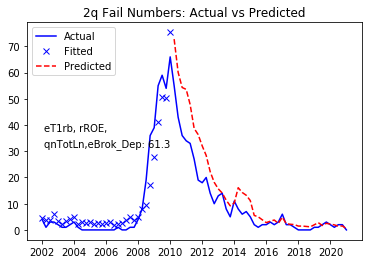

In [53]:
fx = list(fnbr.index)
plt.plot(fx, fnbr['f2'],'b', label='Actual')
plt.plot(fx, fnbr['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f2_0p'],'r--',lw=1.5, label='Predicted')
plt.legend(loc=2)
plt.title('2q Fail Numbers: Actual vs Predicted')
plt.annotate(dv4r[dv4r['idx']==0]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==0]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.show()

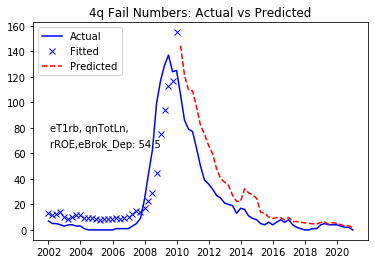

In [54]:
fx = list(fnbr.index)
plt.plot(fx, fnbr['f4'],'b', label='Actual')
plt.plot(fx, fnbr['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f4_2p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==2]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==2]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.legend(loc=2)
plt.title('4q Fail Numbers: Actual vs Predicted')
plt.show()

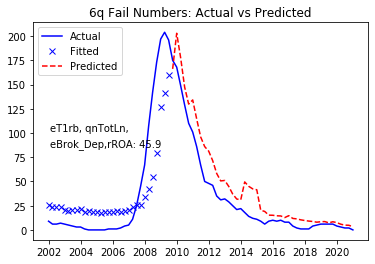

In [55]:
fx = list(fnbr.index)
plt.plot(fx, fnbr['f6'],'b', label='Actual')
plt.plot(fx, fnbr['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f6_4p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==4]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==4]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.legend(loc=2)
plt.title('6q Fail Numbers: Actual vs Predicted')
plt.show()

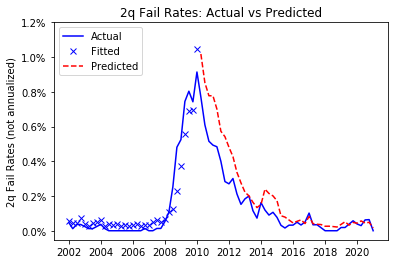

In [56]:
fx = list(fnbr.index)
plt.plot(fx, favg['f2'],'b', label='Actual')
plt.plot(fx, favg['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f2_0p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0121,.002)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('2q Fail Rates (not annualized)')
plt.legend(loc=2)
plt.title('2q Fail Rates: Actual vs Predicted')
plt.show()

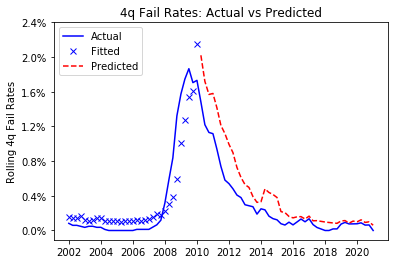

In [57]:
fx = list(fnbr.index)
plt.plot(fx, favg['f4'],'b', label='Actual')
plt.plot(fx, favg['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f4_2p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0241,.004)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 4q Fail Rates')
plt.legend(loc=2)
plt.title('4q Fail Rates: Actual vs Predicted')
plt.show()

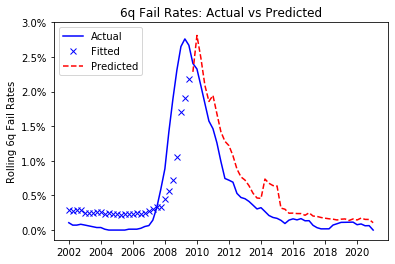

In [58]:
fx = list(fnbr.index)
plt.plot(fx, favg['f6'],'b', label='Actual')
plt.plot(fx, favg['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f6_4p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0301,.005)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 6q Fail Rates')
plt.legend(loc=2)
plt.title('6q Fail Rates: Actual vs Predicted')
plt.show()

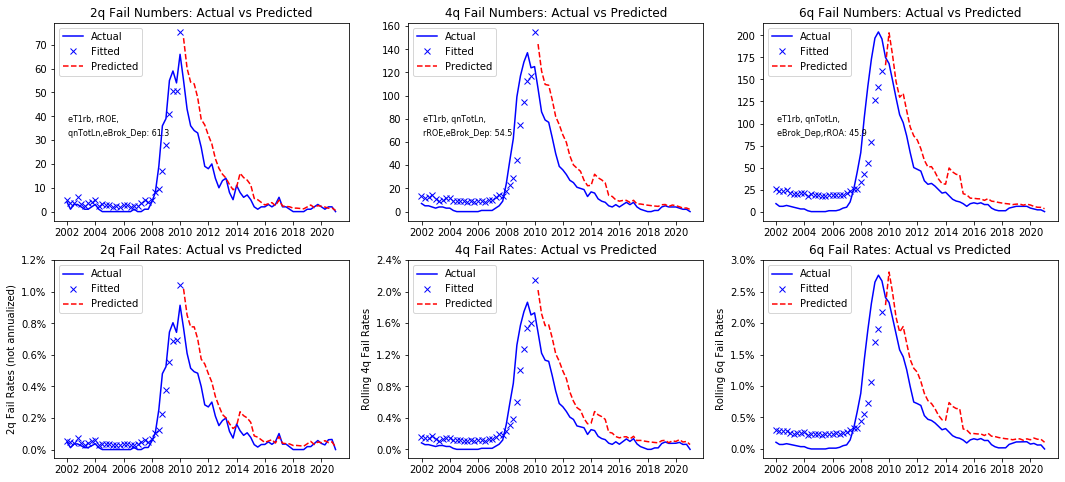

In [59]:
fx = list(fnbr.index)
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*2) )  ## double width, single height

plt.subplot(2, 3, 1)
plt.plot(fx, fnbr['f2'],'b', label='Actual')
plt.plot(fx, fnbr['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f2_0p'],'r--',lw=1.5, label='Predicted')
plt.legend(loc=2)
plt.title('2q Fail Numbers: Actual vs Predicted')
plt.annotate(dv4r[dv4r['idx']==0]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==0]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=8) # var listing annotation

plt.subplot(2, 3, 2)
plt.plot(fx, fnbr['f4'],'b', label='Actual')
plt.plot(fx, fnbr['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f4_2p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==2]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==2]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.legend(loc=2)
plt.title('4q Fail Numbers: Actual vs Predicted')

plt.subplot(2, 3, 3)
plt.plot(fx, fnbr['f6'],'b', label='Actual')
plt.plot(fx, fnbr['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f6_4p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==4]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==4]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.legend(loc=2)
plt.title('6q Fail Numbers: Actual vs Predicted')

plt.subplot(2, 3, 4)
plt.plot(fx, favg['f2'],'b', label='Actual')
plt.plot(fx, favg['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f2_0p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0121,.002)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('2q Fail Rates (not annualized)')
plt.legend(loc=2)
plt.title('2q Fail Rates: Actual vs Predicted')

plt.subplot(2, 3, 5)
plt.plot(fx, favg['f4'],'b', label='Actual')
plt.plot(fx, favg['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f4_2p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0241,.004)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 4q Fail Rates')
plt.legend(loc=2)
plt.title('4q Fail Rates: Actual vs Predicted')

plt.subplot(2, 3, 6)
plt.plot(fx, favg['f6'],'b', label='Actual')
plt.plot(fx, favg['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f6_4p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0301,.005)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 6q Fail Rates')
plt.legend(loc=2)
plt.title('6q Fail Rates: Actual vs Predicted')

plt.savefig('LR_'+alt+str(thresh)+'mm2_2009_nbrvsrate_allmods'+'.png', dpi=400, bbox_inches='tight')

plt.show()

In [60]:
fcol[-6:]

['f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

In [61]:
len(dff) # 523339

523339

In [62]:
ffb = dff[dff['FailDate']>'1999'][['IDRSSD','AsOf','Name','FailDate','eTotAst']+fcol[-6:]].groupby(['IDRSSD']).max()

In [63]:
ffb.sort_index(by='eTotAst',ascending=False,inplace=True)
ffb.reset_index(drop=False,inplace=True)

In [64]:
dff.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8', 'Intercept', 'f2_0', 'f2_1',
       'f4_2', 'f4_3', 'f6_4', 'f6_5'],
      dtype='object')

In [65]:
ffb.tail()

IDRSSD       AsOf                           Name   FailDate  eTotAst  \
506   901956 2007-12-31                      HUME BANK 2008-03-07  19681.0   
507   587574 2009-12-31  ARCOLA HOMESTEAD SAVINGS BANK 2010-06-04  19083.0   
508   359070 2006-09-30      METROPOLITAN SAVINGS BANK 2007-02-02  15760.0   
509  1861347 2003-06-30           PULASKI SAVINGS BANK 2003-11-14  11051.0   
510   475934 2001-12-31           STATE BANK OF LATHAM 2014-06-20   6470.0   

         f2_0      f2_1      f4_2      f4_3      f6_4      f6_5  
506  0.000674  0.000408  0.002633  0.003244  0.006787  0.005495  
507  0.878685  0.824802  0.966948  0.989611  0.983955  0.962353  
508  0.000249  0.000129  0.000904  0.000952  0.002170  0.002031  
509  0.000272  0.000146  0.001196  0.000926  0.002361  0.002742  
510  0.000032  0.000014  0.000151  0.000079  0.000284  0.000437

In [66]:
ffb['Rank'] = ffb['eTotAst'].rank(ascending=False)
ffb.head()

IDRSSD       AsOf                         Name   FailDate       eTotAst  \
0   480228 2020-12-31          BANK OF AMERICA, NA 2009-01-16  2.258832e+09   
1   476810 2020-12-31               CITIBANK, N.A. 2008-11-23  1.661507e+09   
2  1830035 2014-09-30        MBNA AMERICA BANK, NA 2009-01-16  1.967486e+08   
3   486752 2011-03-31  CITIBANK (SOUTH DAKOTA), NA 2008-11-23  1.579352e+08   
4  1469211 2006-12-31            TREASURY BANK, NA 2009-01-16  9.328420e+07   

       f2_0      f2_1      f4_2      f4_3      f6_4      f6_5  Rank  
0  0.001353  0.021969  0.004573  0.006004  0.011461  0.009480   1.0  
1  0.001466  0.022468  0.005379  0.006820  0.012839  0.010796   2.0  
2  0.000785  0.005348  0.006159  0.068699  0.164163  0.014051   3.0  
3  0.024536  0.007371  0.129526  0.122417  0.249025  0.255563   4.0  
4  0.000863  0.002667  0.003388  0.003737  0.008252  0.007527   5.0

In [67]:
dff[dff['mtf']>0][['IDRSSD','mtf']].head(6)

IDRSSD         mtf
1274    2451  102.704368
1275    2451   99.747428
1276    2451   96.757634
1277    2451   93.734984
1278    2451   90.712335
1279    2451   87.755395

In [68]:
############### CAUTION  CAUTION #########################################
## DO NOT RUN UNLESS.....
## short-cut to skip all earlier processing!!!!!!!!!!!!!!!!!
############### CAUTION  CAUTION #########################################

#dff = pd.read_csv('allbanks_f2468_roe0mm2_20091231.csv', index_col=0)
#dff['AsOf'] = pd.to_datetime(dff['AsOf'])
#dff['FailDate'] = pd.to_datetime(dff['FailDate'])
############### CAUTION  CAUTION #########################################

fcol = [x for x in list(dff.columns) if x[0:1]=='f']
xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eBrok_Dep','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
dmtf=dff[dff['mtf2']>0][['mtf2']+xcol+fcol].groupby('mtf2').mean()
targ = pd.to_datetime('2009-12-31')
thresh = 0
alt = 'roe' ## or alt = ''  # add rROE >=-200 screening test

dff.head(2)

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   

    qnTotLn      rNIM     rPPNR      rROA  ...  f4  f6  f8  Intercept  \
0  0.202341  4.771308  2.035791  1.366385  ...   0   0   0        1.0   
1  0.199812  4.673793  1.952308  1.314604  ...   0   0   0        1.0   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  2.058829e-08  2.717914e-08  3.115884e-07  1.946419e-08  3.834514e-07   
1  2.347768e-08  3.114855e-08  3.492824e-07  2.272195e-08  4.348963e-07   

       f6_5  
0  0.000002  
1  0.000002  

[2 rows x 33 columns]

In [69]:
dmtf.head()

rcTotLn    qnTotLn      rNIM     rPPNR      rROA        rROE  \
mtf2                                                                  
1.0   3.910323  13.784797  2.769020 -1.041964 -4.388430 -115.303938   
2.0   3.928962  13.250574  3.079466 -0.964720 -4.506725 -106.633604   
3.0   4.260448  14.265051  2.648951 -1.218548 -4.781614 -110.350981   
4.0   3.995392  13.583828  2.751308 -0.884454 -4.713722 -100.621137   
5.0   3.744506  12.466599  3.164818 -0.643620 -4.330273  -84.885864   

              rEff    eLn_Dep    aFF_TA  eBrok_Dep  ...   f2   f4   f6   f8  \
mtf2                                                ...                       
1.0    6251.945995  77.915089  9.357434  12.510120  ...  1.0  1.0  1.0  1.0   
2.0   13963.397653  78.451595  8.734169  10.104882  ...  1.0  1.0  1.0  1.0   
3.0    2870.687608  77.217124  7.583743  10.502690  ...  1.0  1.0  1.0  1.0   
4.0    8375.599593  84.045683  8.048562  13.320113  ...  1.0  1.0  1.0  1.0   
5.0   11104.486408  80.286756  7.675291  10.372614  ...  1.0  1.0  1.0  1.0   

          f2_0      f2_1      f4_2      f4_3      f6_4      f6_5  
mtf2                                                              
1.0   0.589220  0.604416  0.748429  0.665020  0.694206  0.781355  
2.0   0.544282  0.562045  0.721544  0.638399  0.671415  0.756465  
3.0   0.530514  0.548774  0.732284  0.651280  0.695653  0.777825  
4.0   0.475800  0.486475  0.680208  0.614883  0.661649  0.730008  
5.0   0.350324  0.368994  0.571393  0.515883  0.575265  0.635399  

[5 rows x 24 columns]

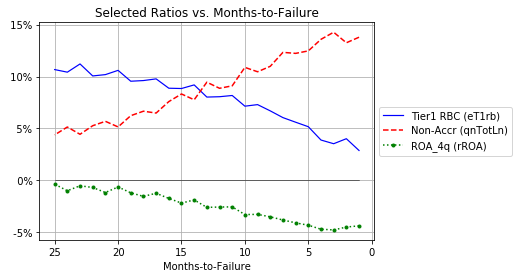

In [70]:
xm = list(dmtf.index)[0:25]
#dmtf.ix[0:25][['rcTotLn','qnTotLn','rROA','eT1rb']].plot()
plt.plot(xm,dmtf.ix[0:25]['eT1rb'],c='b',ls='-',lw=1.2,label='Tier1 RBC (eT1rb)')
plt.plot(xm,dmtf.ix[0:25]['qnTotLn'],c='r',ls='--',label='Non-Accr (qnTotLn)')
#plt.plot(xm,dmtf.ix[0:25]['rcTotLn'],c='b',label='NCO TotLn (r4q)')
plt.plot(xm,dmtf.ix[0:25]['rROA'],c='g',ls=':',lw=1.5,marker='.',label='ROA_4q (rROA)')
#plt.plot(xm,dmtf.ix[0:25]['eBrok_Dep'],c='g',ls='-.',lw=1.5,marker='x',label='Brok%Dep')
plt.plot(xm,[0]*25,'k',lw=.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ytix = np.arange(-5,15.1,5)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.xlabel('Months-to-Failure')
plt.grid()
plt.title("Selected Ratios vs. Months-to-Failure")
plt.gca().invert_xaxis()  ## inverts x-axis!!
plt.savefig('LR_'+alt+str(thresh)+'mm2_2009_ratiosvsmtf'+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [71]:
xm

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0]

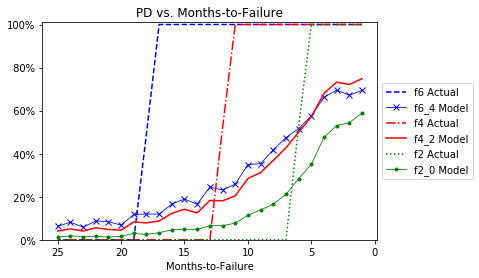

In [72]:
falt = ['f2_0','f4_2','f6_4']
#dmtf.ix[0:25][falt].plot()
plt.plot(xm,dmtf.ix[0:25]['f6'],c='b',ls='--',lw=1.5,label='f6 Actual')
plt.plot(xm,dmtf.ix[0:25]['f6_4'],c='b',ls='-',lw=.8,marker='x',label='f6_4 Model')
plt.plot(xm,dmtf.ix[0:25]['f4'],c='r',ls='-.',lw=1.5,label='f4 Actual')
plt.plot(xm,dmtf.ix[0:25]['f4_2'],c='r',lw=1.5,label='f4_2 Model')
plt.plot(xm,dmtf.ix[0:25]['f2'],c='g',ls=':',lw=1.5,label='f2 Actual')
plt.plot(xm,dmtf.ix[0:25]['f2_0'],c='g',ls='-',lw=.8,marker='.',label='f2_0 Model')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("PD vs. Months-to-Failure")
plt.ylim([0,1.01])
ytix = np.arange(0,1.1,.2)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.xlabel('Months-to-Failure')
plt.gca().invert_xaxis()
plt.savefig('LR_'+alt+str(thresh)+'mm2_2009_pdsvsmtf'+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [73]:
varlst = ['qnTotLn', 'rROA', 'rROE','eBrok_Dep', 'eT1rb','lnTotAst']
varlst

['qnTotLn', 'rROA', 'rROE', 'eBrok_Dep', 'eT1rb', 'lnTotAst']

In [74]:
df11=dff[(dff['AsOf']=='2010-12-31')&(dff['FailDate']>'2011-01-01')&(dff['FailDate']<'2012-01-01')]
df11.sort_index(by='FailDate',inplace=True)
len(df11) # 77

77

In [75]:
df11[['FailDate','Name','State','f2_0','f4_2','f6_4']][0:15]

FailDate                               Name State      f2_0  \
513442 2011-01-07                        LEGACY BANK    AZ  0.383881   
200505 2011-01-21         ENTERPRISE BANKING COMPANY    GA  0.911381   
22229  2011-01-28              FIRST STATE BANK, THE    OK  0.000587   
505554 2011-01-28                      FIRSTIER BANK    CO  0.981772   
95422  2011-01-28               FIRST COMMUNITY BANK    NM  0.874547   
516691 2011-02-04     COMMUNITY FIRST BANK - CHICAGO    IL  0.211582   
504181 2011-02-04                AMERICAN TRUST BANK    GA  0.928992   
484970 2011-02-04                 NORTH GEORGIA BANK    GA  0.972357   
307784 2011-02-11                 PEOPLES STATE BANK    MI  0.947521   
464649 2011-02-11               CANYON NATIONAL BANK    CA  0.719006   
87595  2011-02-11                  BADGER STATE BANK    WI  0.173829   
488087 2011-02-11      SUNSHINE STATE COMMUNITY BANK    FL  0.893632   
109246 2011-02-18                     HABERSHAM BANK    GA  0.862694   
459070 2011-02-18         CITIZENS BANK OF EFFINGHAM    GA  0.883514   
393052 2011-03-11  FIRST NATIONAL BANK OF DAVIS, THE    OK  0.000473   

            f4_2      f6_4  
513442  0.683633  0.344219  
200505  0.987156  0.979969  
22229   0.001759  0.004583  
505554  0.997407  0.970186  
95422   0.976793  0.869417  
516691  0.494842  0.352552  
504181  0.987660  0.913467  
484970  0.996302  0.975699  
307784  0.989779  0.912149  
464649  0.926242  0.760192  
87595   0.436892  0.344686  
488087  0.982217  0.887557  
109246  0.973606  0.908168  
459070  0.976392  0.872018  
393052  0.002586  0.006054

In [76]:
df11[fcol].mean()

f2      0.441558
f4      1.000000
f6      1.000000
f8      1.000000
f2_0    0.430002
f2_1    0.459677
f4_2    0.659798
f4_3    0.586013
f6_4    0.642201
f6_5    0.723777
dtype: float64

In [77]:
df11.to_csv("2011failedbks_pds_20091231_"+alt+str(thresh)+"mm2.csv")

In [78]:
db11=dff[(dff['AsOf']=='2010-12-31')]
db11.sort_index(by='eTotAst',ascending=False,inplace=True)
db11[['Name']+fcol].head(10)

Name  f2  f4  f6  f8      f2_0      f2_1  \
351227       JPMORGAN CHASE BANK, NA   0   0   0   0  0.000820  0.014456   
197526           BANK OF AMERICA, NA   0   0   0   0  0.000529  0.008420   
195410                CITIBANK, N.A.   0   0   0   0  0.000060  0.001051   
184447          WELLS FARGO BANK, NA   0   0   0   0  0.000587  0.008989   
207870                  U.S. BANK NA   0   0   0   0  0.000842  0.008604   
336580                  PNC BANK, NA   0   0   0   0  0.000276  0.002791   
435865         FIA CARD SERVICES, NA   0   0   0   0  0.000071  0.000398   
222253  BANK OF NEW YORK MELLON, THE   0   0   0   0  0.000244  0.002337   
169364             HSBC BANK USA, NA   0   0   0   0  0.000217  0.001738   
204415                 TD BANK, N.A.   0   0   0   0  0.000255  0.000960   

            f4_2      f4_3      f6_4      f6_5  
351227  0.003104  0.003726  0.008269  0.007156  
197526  0.002233  0.002105  0.005292  0.005426  
195410  0.000332  0.000185  0.000727  0.001033  
184447  0.002252  0.002249  0.005145  0.005173  
207870  0.002873  0.003390  0.006687  0.006038  
336580  0.001203  0.000945  0.002598  0.003050  
435865  0.000402  0.000191  0.000735  0.001194  
222253  0.000967  0.000880  0.002202  0.002302  
169364  0.000997  0.000780  0.002296  0.002635  
204415  0.001532  0.000879  0.003200  0.004483

In [79]:
db11.to_csv("2011allbks_pds_20101231_"+alt+str(thresh)+"mm2.csv")

In [80]:
len(dff) # 523339

523339

In [81]:
varlst = ['qnTotLn', 'rROA', 'rROE','eBrok_Dep', 'eT1rb','lnTotAst']
varlst

['qnTotLn', 'rROA', 'rROE', 'eBrok_Dep', 'eT1rb', 'lnTotAst']

In [82]:
dff.to_csv("allbanks_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv")

In [83]:
"allbanks_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv"

'allbanks_f2468_roe0mm2_20091231.csv'

In [84]:
dfr.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8'],
      dtype='object')

In [85]:
len(dfr), len(dff) # 541981, 523339

(541981, 523339)

In [86]:
len(dfh) # 259210

259210

In [87]:
dfh.to_csv("modeldata_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv")

In [88]:
"modeldata_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv"

'modeldata_f2468_roe0mm2_20091231.csv'

In [89]:
dfh.head(2)

IDRSSD       AsOf                    Name FailDate  f2  f4  f6  f8  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY      NaT   0   0   0   0   
1      37 2002-03-31  BANK OF HANCOCK COUNTY      NaT   0   0   0   0   

    rcTotLn   qnTotLn  ...      eT1rb     eTotrb  eALLL_Ln   lnTotAst  \
0  0.320412  0.202341  ...  31.394061  32.659950  2.377511  11.106820   
1  0.261846  0.199812  ...  31.128485  32.396358  2.522930  11.138465   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  2.058829e-08  2.717914e-08  3.115884e-07  1.946419e-08  3.834514e-07   
1  2.347768e-08  3.114855e-08  3.492824e-07  2.272195e-08  4.348963e-07   

       f6_5  
0  0.000002  
1  0.000002  

[2 rows x 28 columns]

In [90]:
dv4b

idx  fx     v1        r1       v2        r2         v3        r3         v4  \
0   0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192  eBrok_Dep   
1   0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   lnTotAst   
2   3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519184  eBrok_Dep   
3   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519948  eBrok_Dep   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROA   
5   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROE   

         r4       Int        c1        c2        c3        c4  
0  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  
1  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  
2  0.544654 -2.212869 -0.400314  0.112573 -0.029294  0.040637  
3  0.541713 -0.929336 -0.523156  0.118067 -0.311230  0.038045  
4  0.459380 -1.267605 -0.418450  0.147419  0.041354 -0.292336  
5  0.458963 -2.073528 -0.342457  0.140638  0.042748 -0.026583

In [91]:
fcol

['f2', 'f4', 'f6', 'f8', 'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

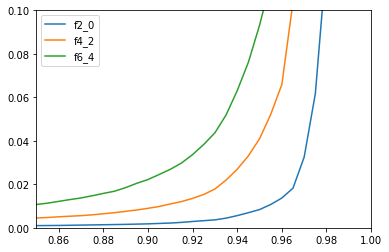

In [92]:
dpc0912 = dff[dff['AsOf']=='2009-12-31'][fcol[-6:]].quantile(np.arange(.01,1,.005))
dpc0912[['f2_0','f4_2','f6_4']].plot()
plt.ylim([0,.1])
plt.xlim([.85,1])
plt.legend(loc=2)

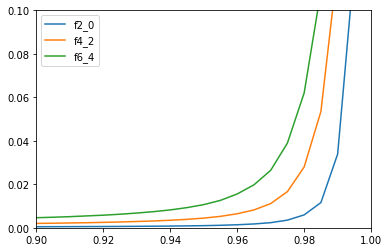

In [93]:
dpc0914 = dff[dff['AsOf']>'2009-01-01'][fcol[-6:]].quantile(np.arange(.01,1,.005))
dpc0914[['f2_0','f4_2','f6_4']].plot()
plt.ylim([0,.1])
plt.xlim([.9,1])
plt.legend(loc=2)

In [94]:
dpc96 = dff[['AsOf']+fcol[-6:]].groupby('AsOf').quantile(.96)
dpc96[['f2_0','f4_2','f6_4']].plot()

In [95]:
dpc90p = dff[['AsOf']+fcol[-6:]].groupby('AsOf').quantile([.9,.92,.94,.96,.98])
dpc90p = dpc90p.unstack(1)
#dpc90p=dpc90p.swaplevel(0,1,axis=1)
dpc90p.sort_index(axis=1,inplace=True)
dpc90p.head(2)

f2_0                                              f2_1  \
                0.90      0.92      0.94      0.96      0.98      0.90   
AsOf                                                                     
2001-12-31  0.000606  0.000668  0.000774  0.000953  0.001395  0.000669   
2002-03-31  0.000587  0.000663  0.000757  0.000920  0.001399  0.000646   

                                                    ...      f6_4            \
                0.92      0.94      0.96      0.98  ...      0.90      0.92   
AsOf                                                ...                       
2001-12-31  0.000755  0.000874  0.001107  0.001656  ...  0.004996  0.005545   
2002-03-31  0.000724  0.000838  0.001064  0.001582  ...  0.004900  0.005539   

                                              f6_5                      \
                0.94      0.96      0.98      0.90      0.92      0.94   
AsOf                                                                     
2001-12-31  0.006362  0.007993  0.012139  0.004450  0.004926  0.005625   
2002-03-31  0.006376  0.007785  0.011998  0.004433  0.004941  0.005677   

                                
                0.96      0.98  
AsOf                            
2001-12-31  0.006959  0.010644  
2002-03-31  0.006933  0.010816  

[2 rows x 30 columns]

In [96]:
dpc90p['f4_2'].plot()

In [97]:
dfr0916 = dfr[dfr['AsOf']>'2009-01-01']
len(dfr0916) # 306303

306303

In [98]:
dfr.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8'],
      dtype='object')

In [99]:
dfr0916.sort_index(by=['AsOf','eTotAst'],ascending=[True,False],inplace=True)
dfr0916.reset_index(drop=True,inplace=True)
dfr0916.tail(2)

IDRSSD       AsOf                      Name State  eTotAst  rcTotLn  \
306301  3268173 2020-12-31  EMIGRANT MERCANTILE BANK    NY   3413.0      0.0   
306302  2337335 2020-12-31      UMB BANK & TRUST, NA    MO   3040.0      0.0   

        qnTotLn        rNIM     rPPNR      rROA  ...      eTotrb  eALLL_Ln  \
306301      0.0    1.143947 -0.760012 -0.555393  ...  426.246334       0.0   
306302      0.0  500.000000  0.164568  0.131655  ...  103.016949       0.0   

        lnTotAst  FailDate  mtf  mtf2  f2  f4  f6 f8  
306301  8.135347       NaT  NaN   NaN   0   0   0  0  
306302  8.019613       NaT  NaN   NaN   0   0   0  0  

[2 rows x 26 columns]

In [100]:
dfr0916.to_csv("allbanks_f2468r_"+alt+str(thresh)+"mm2_2009_202012"+".csv")

In [101]:
dfr0916.tail()

IDRSSD       AsOf                                           Name  \
306298  3952904 2020-12-31  CANANDAIGUA NATIONAL TRUST COMPANY OF FLORIDA   
306299   382274 2020-12-31  KENTLAND FEDERAL SAVINGS AND LOAN ASSOCIATION   
306300  2960788 2020-12-31              WHEATON COLLEGE TRUST COMPANY, NA   
306301  3268173 2020-12-31                       EMIGRANT MERCANTILE BANK   
306302  2337335 2020-12-31                           UMB BANK & TRUST, NA   

       State  eTotAst  rcTotLn   qnTotLn        rNIM     rPPNR      rROA  ...  \
306298    FL   4018.0      0.0  0.000000    0.460995  2.614708  1.860465  ...   
306299    IN   3670.0      0.0  1.592649    3.964640 -0.668166 -0.668166  ...   
306300    IL   3627.0      0.0  0.000000    0.883457 -1.637666 -1.228250  ...   
306301    NY   3413.0      0.0  0.000000    1.143947 -0.760012 -0.555393  ...   
306302    MO   3040.0      0.0  0.000000  500.000000  0.164568  0.131655  ...   

             eTotrb  eALLL_Ln  lnTotAst  FailDate  mtf  mtf2  f2  f4  f6 f8  
306298   426.352129  0.000000  8.298540       NaT  NaN   NaN   0   0   0  0  
306299     0.000000  0.918836  8.207947       NaT  NaN   NaN   0   0   0  0  
306300  2241.176471  0.000000  8.196161       NaT  NaN   NaN   0   0   0  0  
306301   426.246334  0.000000  8.135347       NaT  NaN   NaN   0   0   0  0  
306302   103.016949  0.000000  8.019613       NaT  NaN   NaN   0   0   0  0  

[5 rows x 26 columns]

In [102]:
dff0916 = dff[dff['AsOf']>'2009-01-01']
len(dff0916) # 293354

293354

In [103]:
dff0916.sort_index(by=['AsOf','eTotAst'],ascending=[True,False],inplace=True)
dff0916.reset_index(drop=True,inplace=True)
dff0916.head(2)

IDRSSD       AsOf                     Name State       eTotAst   rcTotLn  \
0  852218 2009-03-31  JPMORGAN CHASE BANK, NA    OH  1.688164e+09  1.373904   
1  480228 2009-03-31      BANK OF AMERICA, NA    NC  1.432862e+09  1.475853   

    qnTotLn      rNIM     rPPNR      rROA  ...  f4  f6  f8  Intercept  \
0  2.496176  2.523947  1.918733  0.699537  ...   0   0   0        1.0   
1  3.152932  2.483742  1.831558  0.455510  ...   0   0   0        1.0   

       f2_0      f2_1      f4_2      f4_3      f6_4      f6_5  
0  0.000950  0.016342  0.003298  0.004182  0.008253  0.006957  
1  0.001321  0.021857  0.004573  0.006004  0.011461  0.009480  

[2 rows x 33 columns]

In [104]:
dff0916.to_csv("allbanks_f2468_"+alt+str(thresh)+"mm2_2009_202012"+".csv")

In [105]:
dff201812 = dff[dff['AsOf']=='2018-6-30']
len(dff201812) # 5528

5528

In [106]:
dff201812.to_csv("allbanks_f2468r_"+alt+str(thresh)+"mm2_202012"+".csv")

In [107]:
"allbanks_f2468r_"+alt+str(thresh)+"mm2_202012"+".csv"

'allbanks_f2468r_roe0mm2_202012.csv'

In [108]:
dff201812.tail()

IDRSSD       AsOf                            Name State    eTotAst  \
541718  4845861 2018-06-30                    PRIMARY BANK    NH   178905.0   
541747  5050028 2018-06-30  INTERNATIONAL BANK OF COMMERCE    OK  1559508.0   
541761  5082382 2018-06-30             BANK OF AUSTIN, THE    TX    99951.0   
541776  5086072 2018-06-30                  BLUE GATE BANK    CA   121841.0   
541792  5143788 2018-06-30       WINTER PARK NATIONAL BANK    FL   188809.0   

         rcTotLn  qnTotLn      rNIM     rPPNR      rROA  ...  f4  f6  f8  \
541718  0.000000  0.00000  3.134475  0.557806  0.087969  ...   0   0   0   
541747  0.112062  0.32183  3.792011  1.743767  1.188098  ...   0   0   0   
541761  0.000000  0.00000  2.854703 -4.638150 -5.278749  ...   0   0   0   
541776  0.000000  0.00000  2.254763 -3.017335 -3.404005  ...   0   0   0   
541792  0.000000  0.00000  2.577800 -0.132228 -1.057223  ...   0   0   0   

        Intercept          f2_0          f2_1          f4_2          f4_3  \
541718        1.0  4.134723e-05  3.750522e-05  2.461790e-04  1.148127e-04   
541747        1.0  7.167720e-05  1.698753e-04  3.289408e-04  1.931873e-04   
541761        1.0  8.002084e-11  1.688760e-10  3.110403e-09  1.811952e-10   
541776        1.0  9.860097e-08  1.640316e-07  1.420405e-06  2.419979e-07   
541792        1.0  1.432188e-08  2.783189e-08  2.459137e-07  2.017071e-08   

                f6_4          f6_5  
541718  4.698908e-04  7.456952e-04  
541747  6.115649e-04  8.751714e-04  
541761  1.201473e-08  4.482569e-08  
541776  3.503189e-06  8.522634e-06  
541792  4.336283e-07  1.860973e-06  

[5 rows x 33 columns]